In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import time

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.planar_clusters.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *

import meshcat
import meshcat.geometry as meshcat_geom

In [2]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()

base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/
Meshcat url:  http://127.0.0.1:7004/static/


In [66]:
# Draw a random sample from the grammar and visualize it.
vis.delete()
torch.random.manual_seed(2)
grammar = SpatialSceneGrammar(
    root_node_type = Desk,
    root_node_tf = torch.eye(4)
)
tree = grammar.sample_tree(detach=True)
observed_nodes = tree.get_observed_nodes()

with open("sampled_scenes_3.dat", "rb") as f:
    import pickle
    samples = pickle.load(f)
tree, observed_nodes = samples[0]
print("Sampled scene with %d papers, %d plates, %d pencils." % 
       (len(tree.find_nodes_by_type(Paper)),
        len(tree.find_nodes_by_type(Plate)),
        len(tree.find_nodes_by_type(Pencil))))
print("Sampled tree has score %f" % tree.score().item())
draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url)
draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, alpha=0.5, node_sphere_size=0.01)

Sampled scene with 8 papers, 0 plates, 0 pencils.
Sampled tree has score 18.458221
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6004...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/
Connected to meshcat-server.
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/


Super tree has 73 nodes


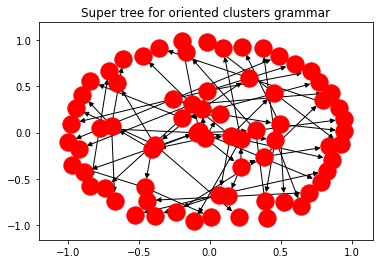

In [67]:
# Draw supertree for this grammar
super_tree = grammar.make_super_tree(max_recursion_depth=10, detach=True)
nx.draw_networkx(super_tree, with_labels=False)
plt.title("Super tree for oriented clusters grammar")
print("Super tree has %d nodes" % len(list(super_tree.nodes)))

In [68]:
# Parse this tree
inference_results = infer_mle_tree_with_mip(
    grammar, observed_nodes, verbose=True,
    max_scene_extent_in_any_dir=10.
)
mip_optimized_tree = get_optimized_tree_from_mip_results(inference_results)
draw_scene_tree_contents_meshcat(mip_optimized_tree, zmq_url=vis.window.zmq_url, prefix="mip")
draw_scene_tree_structure_meshcat(mip_optimized_tree, zmq_url=vis.window.zmq_url, prefix="mip_scene_tree")

for node in mip_optimized_tree:
    err = torch.matmul(node.rotation.transpose(0, 1), node.rotation) - torch.eye(3)
    print("Avg elementwise deviation from R^T R = I: ", err.abs().mean())

Starting setup.
Activation vars allocated.
Continuous variables allocated.
Setup time:  1.2005727291107178
Num vars:  7100
Num constraints:  26055
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Fri Sep  3 00:26:49 2021

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 19553 rows, 7244 columns and 126420 nonzeros
Model fingerprint: 0x6b5daad2
Model has 36 quadratic constraints
Variable types: 6906 continuous, 338 integer (338 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [2e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-02, 1e+01]
Presolve removed 17154 rows and 5714 columns
Presolve time: 0.19s
Presolved: 2399 rows, 1530 columns, 15716 nonzeros
Presolved model has 36 quadratic constraint(s)
Variable types: 1411 continuous, 119 integer (119 binary)

Root relaxation: objective 1.123022e+01, 740 iterations, 0.03 seconds

    Nodes    

In [90]:
# Do NLP refinement of tree
refinement_results = optimize_scene_tree_with_nlp(mip_optimized_tree, verbose=True)
refined_tree = refinement_results.refined_tree
draw_scene_tree_contents_meshcat(refined_tree, zmq_url=vis.window.zmq_url, prefix="mip_refined")
draw_scene_tree_structure_meshcat(refined_tree, zmq_url=vis.window.zmq_url, prefix="mip_refined_scene_tree")

Success?:  True
Logfile: 

         S N O P T  7.4-1.2  (Feb 2015)
1
 
 SNMEMA EXIT 100 -- finished successfully
 SNMEMA INFO 104 -- memory requirements estimated

 
 ===>  WARNING - Column      1 of the Jacobian is empty.
 ===>  WARNING - Column      2 of the Jacobian is empty.
 ===>  WARNING - Column      3 of the Jacobian is empty.
 ===>  WARNING - Column      4 of the Jacobian is empty.
 ===>  WARNING - Column      5 of the Jacobian is empty.
 ===>  WARNING - Column      6 of the Jacobian is empty.
 ===>  WARNING - Column    160 of the Jacobian is empty.
 ===>  WARNING - Column    161 of the Jacobian is empty.
 ===>  WARNING - Column    162 of the Jacobian is empty.
 ===>  WARNING - Column    172 of the Jacobian is empty.
 ===>  WARNING - Column    173 of the Jacobian is empty.
 ===>  WARNING - Column    174 of the Jacobian is empty.
 ===>  WARNING - Column    181 of the Jacobian is empty.
 ===>  WARNING - Column    182 of the Jacobian is empty.
 ===>  WARNING - Column    183 of th

In [91]:
try:
    mip_optimized_tree.score()
except ValueError as e:
    print("MIP optimized tree wasn't happy, as expected: %s" % str(e))

print(refined_tree.score(verbose=False))

tensor([18.4582])


In [98]:
# Now try to do MCMC on the parsed tree
def do_vis(tree):
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="sampled_in_progress")

sampled_trees = do_fixed_structure_mcmc(
    grammar, refined_tree, num_samples=10, verbose=1, perturb_in_config_space=True,
    vis_callback=do_vis, translation_variance=1.0, rotation_variance=1.0,
    do_hit_and_run_postprocess=False
)

New score 18.458221, old score 18.458221, alpha 1.000000
0: Accept rate 1.000000
New score 18.458221, old score 18.458221, alpha 1.000000
1: Accept rate 1.000000
New score 18.458221, old score 18.458221, alpha 1.000000
2: Accept rate 1.000000
New score 18.458221, old score 18.458221, alpha 1.000000
3: Accept rate 1.000000
New score 18.458221, old score 18.458221, alpha 1.000000
4: Accept rate 1.000000
New score 18.458221, old score 18.458221, alpha 1.000000
5: Accept rate 1.000000
New score 18.458221, old score 18.458221, alpha 1.000000
6: Accept rate 1.000000
New score 18.458221, old score 18.458221, alpha 1.000000
7: Accept rate 1.000000
New score 18.458221, old score 18.458221, alpha 1.000000
8: Accept rate 1.000000
New score 18.458221, old score 18.458221, alpha 1.000000
9: Accept rate 1.000000


In [95]:
for sample_k, sampled_tree in enumerate(sampled_trees[::5]):
    draw_scene_tree_structure_meshcat(sampled_tree, zmq_url=vis.window.zmq_url, prefix="sampled/%d" % sample_k)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/
